In [1]:
import torch
from tqdm import tqdm
from monai.utils import set_determinism
from torch.cuda.amp import autocast
# from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet,AutoencoderKL
from generative.networks.schedulers import DDPMScheduler
import cv2
from generative.networks.schedulers.ddim import DDIMScheduler

In [2]:
from torch.utils.data import Dataset, DataLoader
import glob
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
set_determinism(42)
torch.cuda.empty_cache()

In [4]:
## Load autoencoder

device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
PATH_auto = '/home/default/monai_generative_ai/auto_encoder_model.pt'

autoencoderkl.load_state_dict(torch.load(PATH_auto))
autoencoderkl = autoencoderkl.to(device)

#### Load unet and embedings

embedding_dimension = 64
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
    with_conditioning=True,
    cross_attention_dim=embedding_dimension
)

embed = torch.nn.Embedding(num_embeddings=6, embedding_dim=embedding_dimension, padding_idx=0)
PATH_check_point = '/home/default/monai_generative_ai/archv/checkpoints_generate_knee_condition/250.pth'
checkpoint = torch.load(PATH_check_point)

PATH_unet_condition = '/home/default/monai_generative_ai/unet_latent_space_model_condition.pt'
PATH_embed_condition = '/home/default/monai_generative_ai/embed_latent_space_model_condition.pt'

# unet.load_state_dict(torch.load(PATH_unet_condition))
# embed.load_state_dict(torch.load(PATH_embed_condition))

unet.load_state_dict(checkpoint['model_state_dict'])
embed.load_state_dict(checkpoint['embed_state_dict'])

unet.to(device)
embed.to(device)
# scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
# scale_factor = 0.943597137928009
# inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

Embedding(6, 64, padding_idx=0)

In [5]:
scheduler = DDIMScheduler(num_train_timesteps=1000,schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

In [6]:
class CustomDataset(Dataset):
  def __init__(self,path):
    self.imgs_path = path
    file_list = glob.glob(self.imgs_path+ "*")

    self.data=[]
    for class_path in file_list:
      class_name = class_path.split("/")[-1]
      for img_path in glob.glob(class_path+"/*"):
          self.data.append([img_path,1+int(class_name)])
        # self.data.append([img_path,1 if class_name=="0" or class_name =="1" else 2])

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    img_path,class_id = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img,(112,112)) # resizing here
    gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_image.resize(112,112,1)
    img_tensor = torch.from_numpy(gray_image*1.0)
    img_tensor = img_tensor.permute(2,0,1)
    class_id = torch.tensor([class_id])
    img_tensor /= 255.
    return img_tensor.float() , class_id.squeeze()

In [16]:
## Define the custom dataset
training_dataset = CustomDataset('/home/default/monai_generative_ai/Knee_Osteoarthritis/train/')
validation_dataset = CustomDataset('/home/default/monai_generative_ai/Knee_Osteoarthritis/val/')

In [17]:
len(training_dataset)

5778

In [18]:
batch_size = 64
train_loader_ = DataLoader(
    training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
for train_batch in train_loader_:
    break

idx_unhealthy = np.argwhere(train_batch[1].numpy() == 5).squeeze()

idx = idx_unhealthy[random.randint(0, len(idx_unhealthy)-1)]  # Pick a random slice of the validation set to be transformed
inputting = train_batch[0][idx]  # Pick an input slice of the validation set to be transformed
inputlabel = train_batch[1][idx]  # Check whether it is healthy or diseased

# plt.figure("input" + str(inputlabel))
# plt.imshow(inputting[0], cmap="gray")
# plt.axis("off")
# plt.tight_layout()
# plt.show()

# # model.eval()
# print("input label: ", inputlabel)

In [19]:
data = np.argwhere(train_batch[1].numpy() == 5).squeeze()

In [20]:
idx

12

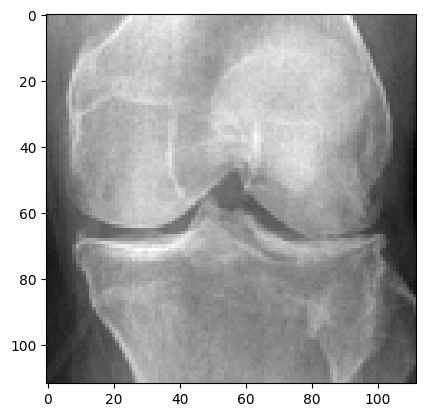

In [65]:
plt.figure("input" + str(inputlabel))
plt.imshow(inputting[0], cmap="gray")

# # model.eval()
# print("input label: ", inputlabel)

In [23]:
input = inputting.reshape((1,1,112,112))

In [24]:
inputting.shape

torch.Size([1, 112, 112])

In [25]:
input.shape

torch.Size([1, 1, 112, 112])

In [26]:
z_mu, z_sigma = autoencoderkl.encode(input.to(device))

In [27]:
z = autoencoderkl.sampling(z_mu, z_sigma)

In [28]:
z.device

device(type='cuda', index=0)

In [29]:
unet.eval()

guidance_scale = 3.0
total_timesteps = 1000
latent_space_depth = int(total_timesteps * 0.5)

current_img = z
current_img = current_img.float()
scheduler.set_timesteps(num_inference_steps=total_timesteps)

In [30]:
## Encoding

scheduler.clip_sample = False
class_embedding = embed(torch.zeros(1).long().to(device)).unsqueeze(1)

In [31]:
class_embedding

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       device='cuda:0', grad_fn=<UnsqueezeBackward0>)

## Move to latent space by using reverse diffusion (30 steps)

In [32]:
progress_bar = tqdm(range(30))
for i in progress_bar:  # go through the noising process
    t = i
    with torch.no_grad():
        model_output = unet(current_img, timesteps=torch.Tensor((t,)).to(current_img.device), context=class_embedding)
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)
    progress_bar.set_postfix({"timestep input": t})

latent_img = current_img

100%|███████████| 30/30 [00:00<00:00, 48.53it/s, timestep input=29]


## Move from latent to healthy (500 steps)

In [33]:
## Decoding
conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(device)
class_embedding = embed(conditioning).unsqueeze(1)

progress_bar = tqdm(range(500))
for i in progress_bar:  # go through the denoising process
    t = latent_space_depth - i
    current_img_double = torch.cat([current_img] * 2)
    with torch.no_grad():
        model_output = unet(
            current_img_double, timesteps=torch.Tensor([t, t]).to(current_img.device), context=class_embedding
        )
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    current_img, _ = scheduler.step(noise_pred, t, current_img)
    progress_bar.set_postfix({"timestep input": t})
    torch.cuda.empty_cache()

100%|██████████| 500/500 [00:10<00:00, 46.95it/s, timestep input=1]


In [34]:
current_img_decode = autoencoderkl.decode(current_img)

In [35]:
current_img_decode.shape

torch.Size([1, 1, 112, 112])

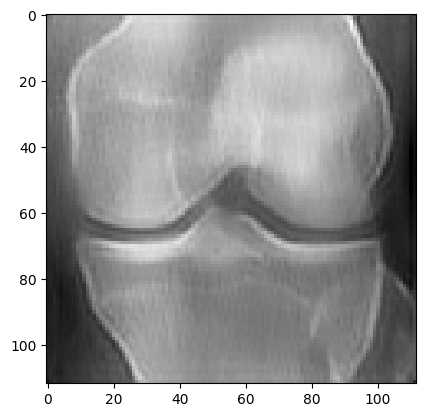

In [36]:
plt.imshow(current_img_decode[0][0].to('cpu').detach().numpy(),cmap='gray')

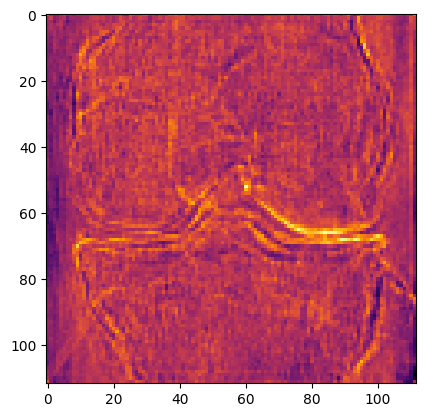

In [37]:
plt.imshow(inputting[0] - current_img_decode[0][0].to('cpu').detach().numpy(), cmap="inferno")

In [38]:
img = current_img_decode[0][0].to('cpu').detach().numpy()

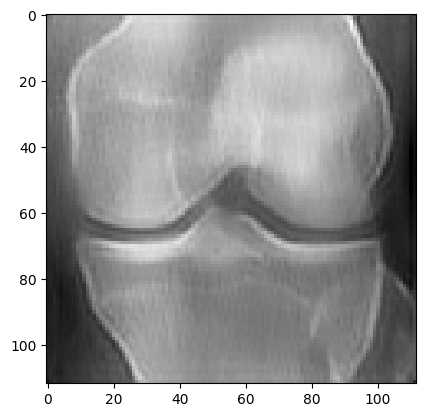

In [47]:
plt.imshow(img,cmap='gray')

In [57]:
img_new = img*255.0

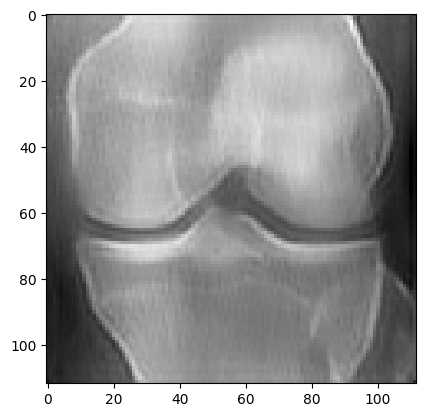

In [59]:
plt.imshow(img_new,cmap = 'gray')